In [55]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy.ma as ma

In [87]:
baseDir = "./save/server2Models/vrnn/vrnn24/"
meansVT = torch.load(baseDir+"validation_means", map_location="cpu")
stdsVT = torch.load(baseDir+"validation_stds", map_location="cpu")
targetsVT = torch.load(baseDir+"validation_targets", map_location="cpu")
inputsVT = torch.load(baseDir+"validation_datas", map_location="cpu")
meansTT = torch.load(baseDir+"train_means", map_location="cpu")
stdsTT = torch.load(baseDir+"train_stds", map_location="cpu")
targetsTT = torch.load(baseDir+"train_targets", map_location="cpu")
inputsTT = torch.load(baseDir+"train_datas", map_location="cpu")
trainDataMean = torch.load(baseDir+"train_mean", map_location="cpu")
trainDataStd = torch.load(baseDir+"train_std", map_location="cpu")
valDataMean = torch.load(baseDir+"val_mean", map_location="cpu")
valDataStd = torch.load(baseDir+"val_std", map_location="cpu")
avgTrainKLDLosses = torch.load(baseDir+"mean_train_kld_losses_per_timestep", map_location="cpu")
avgValKLDLosses = torch.load(baseDir+"mean_validation_kld_losses_per_timestep", map_location="cpu")
plotTrainKLDLosses = torch.load(baseDir+"plot_train_kld_losses", map_location="cpu")
plotValKLDLosses = torch.load(baseDir+"plot_val_kld_losses", map_location="cpu")
plotTrainReconLosses = torch.load(baseDir+"plot_train_recon_losses", map_location="cpu")
plotValReconLosses = torch.load(baseDir+"plot_val_recon_losses", map_location="cpu")
learningRates = torch.load(baseDir+"learningRates", map_location="cpu")
dataTimesArrTrain = np.array(torch.load(baseDir+"dataTimesArrTrain", map_location="cpu"))
dataTimesArrTrain = np.reshape(dataTimesArrTrain, (-1, dataTimesArrTrain.shape[-1]))
targetTimesArrTrain = np.array(torch.load(baseDir+"targetTimesArrTrain", map_location="cpu"))
targetTimesArrTrain = np.reshape(targetTimesArrTrain, (-1, targetTimesArrTrain.shape[-1]))
dataTimesArrVal = np.array(torch.load(baseDir+"dataTimesArrVal", map_location="cpu"))
dataTimesArrVal = np.reshape(dataTimesArrVal, (-1, dataTimesArrVal.shape[-1]))
targetTimesArrVal = np.array(torch.load(baseDir+"targetTimesArrVal", map_location="cpu"))
targetTimesArrVal = np.reshape(targetTimesArrVal, (-1, targetTimesArrVal.shape[-1]))

In [88]:
trainTimeOrder = dataTimesArrTrain[:,0].argsort()
valTimeOrder = dataTimesArrVal[:,0].argsort()
dataTimesArrTrain = dataTimesArrTrain[trainTimeOrder]
targetTimesArrTrain = targetTimesArrTrain[trainTimeOrder]
dataTimesArrVal = dataTimesArrVal[valTimeOrder]
targetTimesArrVal = targetTimesArrVal[valTimeOrder]
meansT = np.concatenate([p for p in meansTT], axis=1)[:,trainTimeOrder,:]
stdsT = np.concatenate([p for p in stdsTT], axis=1)[:,trainTimeOrder,:]
targetsT = np.concatenate([t for t in targetsTT], axis=1)[:,trainTimeOrder,:]
datasT = np.concatenate([d for d in inputsTT], axis=1)[:,trainTimeOrder,:]
meansV = np.concatenate([p for p in meansVT], axis=1)[:,valTimeOrder,:]
stdsV = np.concatenate([p for p in stdsVT], axis=1)[:,valTimeOrder,:]
targetsV = np.concatenate([t for t in targetsVT], axis=1)[:,valTimeOrder,:]
datasV = np.concatenate([d for d in inputsVT], axis=1)[:,valTimeOrder,:]

In [89]:
def getScaledSamples(generatorMean, generatorStd, dataMean, dataStd):
    standardizedSamples = np.random.normal(generatorMean, generatorStd, size=(100, generatorMean.shape[0]))
    samples = (standardizedSamples * dataStd) + dataMean
    meanofsamples = np.mean(samples, axis=0)
    stdofsamples = np.std(samples, axis=0)
    return samples, meanofsamples, stdofsamples

In [90]:
def inMinutes(td):
    return (td.seconds//60)%60

In [144]:
def plotNHours(means, stds, targets, datas, dataset, dataMean, dataStd, targetTimes, N=24):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    sequenceTrueMean = []
    sequenceTrueStd = []
    sequenceSampleMean = []
    sequenceSampleStd = []
    sequenceTarget = []
    sequenceTimes = []
    shouldMask = []
    maskindex = []
    lastTime = None
    for tStep in range(N):
        realIndex = instance + 12 * tStep
        if realIndex >= means.shape[1]:
            break
        if lastTime and inMinutes(targetTimes[realIndex, -1] - lastTime) > 5:
            shouldMask += [True]
        else:
            shouldMask += [False]
        lastTime = targetTimes[realIndex, -1]
        maskindex += [len(sequenceTrueMean)]
        m = means[:, realIndex, sensor]
        std = stds[:, realIndex, sensor]
        predSamples, sampleMean, sampleStd = getScaledSamples(m, std, dataMean, dataStd)
        sequenceTrueMean += list(m)
        sequenceTrueStd += list(std)
        sequenceSampleMean += list(sampleMean)
        sequenceSampleStd += list(sampleStd)
        sequenceTarget += list(targets[:, realIndex, sensor])
        sequenceTimes += list(targetTimes[realIndex])
        
    #f, ax = plt.subplots(2, sharex=True)
    #f.subplots_adjust(hspace=.5)
    """
    maskedSampleMean = ma.array(sequenceSampleMean)
    maskedTarget = ma.array(sequenceTarget)
    print(maskindex)
    print(shouldMask)
    print(maskedSampleMean.shape)
    for idx, should in zip(maskindex, shouldMask):
        if should:
            maskedSampleMean[idx] = ma.masked
            maskedTarget[idx] = ma.masked
    """
    plt.plot(sequenceTimes, sequenceSampleMean, label="pred")
    plt.plot(sequenceTimes, sequenceTarget, label="target")
    plt.xticks(rotation=90)
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax=plt.gca()
    ax.xaxis.set_major_formatter(xfmt)
    plt.legend()
    plt.ylabel("mile/h")
    plt.ylim((10,90))

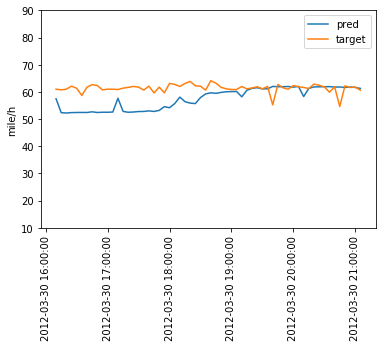

In [147]:
plotNHours(meansT, stdsT, targetsT, datasT, "Train", trainDataMean, trainDataStd, targetTimesArrTrain, N=5)

In [ ]:
def plotRandomInstanceVRNN(means, stds, targets, datas, dataset, dataMean, dataStd):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    m = means[:, instance, sensor]
    std = stds[:, instance, sensor]
    print(m)
    print(std)
    t = targets[:, instance, sensor]
    d = datas[:,instance, sensor]
    predSamples, samplesMean, samplesStd = getScaledSamples(m, std, dataMean, dataStd)
    f, ax = plt.subplots(2, sharex=True)
    f.subplots_adjust(hspace=.5)
    ax[0].plot(range(0,60, 5),samplesMean, label="pred")
    ax[0].fill_between(range(0,60, 5),samplesMean-1.96*samplesStd, samplesMean+1.96*samplesStd, alpha=0.5)
    ax[0].plot(range(0,60, 5),t, label="target")
    ax[0].plot(range(-60,0, 5), d, label="input")
    ax[0].legend()
    ax[0].set_xlabel("Minutes relative to prediction time")
    ax[0].set_ylabel("Speed (mph)")
    ax[0].set_title("random sensor sample {}".format(dataset))
    ax[1].plot(range(0,60, 5), m, label="mean")
    ax[1].fill_between(range(0,60, 5),m-1.96*std, m+1.96*std, alpha=0.5)
    ax[1].set_title("True mean and 95% C.I.")

In [ ]:
plotRandomInstanceVRNN(meansT,stdsT, targetsT, datasT, "Train", trainDataMean, trainDataStd)

In [ ]:
plotRandomInstanceVRNN(meansV, stdsV, targetsV, datasV, "Validation", valDataMean, valDataStd)

In [ ]:
plt.plot(avgTrainKLDLosses)

In [ ]:
plt.plot(avgValKLDLosses)

In [ ]:
def plotTrainValCurve(trainLosses, valLosses, trainKLDLosses=None, valKLDLosses=None):
    plot_every = 1
    plt.rcParams.update({'font.size': 8})
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("loss", color="r")
    ax1.tick_params('y', colors='r')
    ax1.plot(np.arange(1, len(trainLosses)+1)*plot_every, trainLosses, "r--", label="train reconstruction loss")
    ax1.plot(np.arange(1, len(valLosses)+1)*plot_every, valLosses, color="red", label="validation reconstruction loss")
    ax1.legend(loc="upper left")
    ax1.grid()
    if trainKLDLosses:
        ax2 = ax1.twinx()
        ax2.set_ylabel("KLD Loss", color="b")
        ax2.tick_params('y', colors='b')
        ax2.plot(np.arange(1, len(trainKLDLosses)+1)*plot_every, trainKLDLosses, "b--", label="train KLD loss")
        ax2.plot(np.arange(1, len(valKLDLosses)+1)*plot_every, valKLDLosses, color="blue", label="val KLD loss")
        ax2.legend(loc="upper right")
        ax2.grid()
    plt.title("Losses for VRNN")

In [ ]:
plotTrainValCurve(plotTrainReconLosses, plotValReconLosses, plotTrainKLDLosses, plotValKLDLosses)

In [ ]:
learningRates

In [ ]:
# dataTimesArrTrain = dataTimesArrTrain[dataTimesArrTrain[:,0].argsort()]
# targetTimesArrTrain = targetTimesArrTrain[targetTimesArrTrain[:,0].argsort()]

In [ ]:
# td = (dataTimesArrTrain[1,0] - dataTimesArrTrain[0,0])
# (td.seconds//60)%60

In [ ]:
dataTimesArrTrain[:,0].argsort()

In [ ]:
def getNextNIndices(timesArr, sortingIndex):